# MNIST classification

**Course:** 02506 Advanced Image Analysis Spring 21

**Authors:**  Allan Erlang Videbæk (s164197), Mads Emil Dahlgaard (s164206) and Niels Asp Nielsen (s164181).

In [30]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from helpers import read_mnist, format_data, load_nn

***

## Explanation of project
This notebook serves as a demonstration of the trained MNIST classifier. Run this notebook to get classification results on previously unseen data.

### Code structure

The only used 3rd party libraries are NumPy and Matplotlib.
```
.
├── mnist                   # MNIST data.
├── models                  # Trained models saved as pickles.
├── nn.py                   # Code for Neural Network.
├── augmentation.py         # Code for augmenting the MNIST dataset.
├── helpers.py              # Helper functions for data handling.
├── demonstration.ipynb     # Notebook for hand in and evaluation on test set.
├── .gitignore
└── README.md
```

### Pre-processing

We use data augmentation in order to expand the training set and add diversity. We expect that this will increase the model's ability to generalize. 

For data augmentation we use
- Additive (Gaussian) noise.
- Rotation between -25 and 25 degrees.
- Mirroring and 180 degrees rotation (only of 0 and 8).
- Elastic deformation.

### Model selection

The data set is split into a training set of 48000 images and a validation set of 12000 images. The best model is selected as the model performing best on the test set.

All models are trained using 200 epochs and a batch size of 200.

| Architecture | Hyper params | Augmentation | Validation set accuracy |
| :--- | :--- | :--- | ---: |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.5]  | No | .966 |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.9]  | No | .971 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | No | .972 |
| MLP [784, 400, 200, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | .977|
| MLP [784, 500, 300, 10] | [$\eta$=0.001, $\gamma$=0.9]  | Yes | .979 |
| MLP [784, 800, 10] | [$\eta$=0.001, $\gamma$=0.9] | Yes | .979 |

***

## Evaluating on unseen data

### Load data and neural network model

Specify paths to the data below. By default these are set to the 10k test images.

In [31]:
im_path = 'mnist/t10k-images-idx3-ubyte'
lab_path = 'mnist/t10k-labels-idx1-ubyte'
ims, labels, a, t = read_mnist(im_path, lab_path)
# Format X as (n_obs, n_features) and onehot encode y.
X, y = format_data(ims, labels)

In [32]:
print(f"Shape of X: {X.shape}, shape of y: {y.shape}")

Shape of X: (10000, 784), shape of y: (10000, 10)


In [71]:
# Load neural network model.
nn = load_nn('models/0.980.pkl')

In [72]:
print(f"The neural network has {nn.num_layers} layers.")
for i, num_units in enumerate(nn.layers):
    print(f"Layer {i} has {num_units} units.")
print(f"The learning rate of the network during training is {nn.lr}.")
if nn.momentum>0:
    print(f"The neural network used momentum of {nn.momentum} during training.")

The neural network has 4 layers.
Layer 0 has 784 units.
Layer 1 has 500 units.
Layer 2 has 300 units.
Layer 3 has 10 units.
The learning rate of the network during training is 0.001.
The neural network used momentum of 0.9 during training.


### Run and evaluate model on the data

In [73]:
yhat, _, _ = nn.forward(X)
pred_labels = np.argmax(yhat,axis=1)

In [74]:
print(f"The classification accuracy is {np.mean(pred_labels==labels)}.")

The classification accuracy is 0.9807.


***

## Investigating the misclassifications

In [68]:
# Get missclassifications.
misses = pred_labels!=labels
miss_preds = pred_labels[misses]
miss_labels = labels[misses]
miss_ims = ims[misses]

In [69]:
print(f"Total misclassifications: {len(miss_labels)}")
for i in range(10):
    print(f"Misclassifications with true label {i}: {np.sum(miss_labels==i)}.")

Total misclassifications: 228
Misclassifications with true label 0: 14.
Misclassifications with true label 1: 15.
Misclassifications with true label 2: 22.
Misclassifications with true label 3: 21.
Misclassifications with true label 4: 21.
Misclassifications with true label 5: 24.
Misclassifications with true label 6: 19.
Misclassifications with true label 7: 24.
Misclassifications with true label 8: 34.
Misclassifications with true label 9: 34.


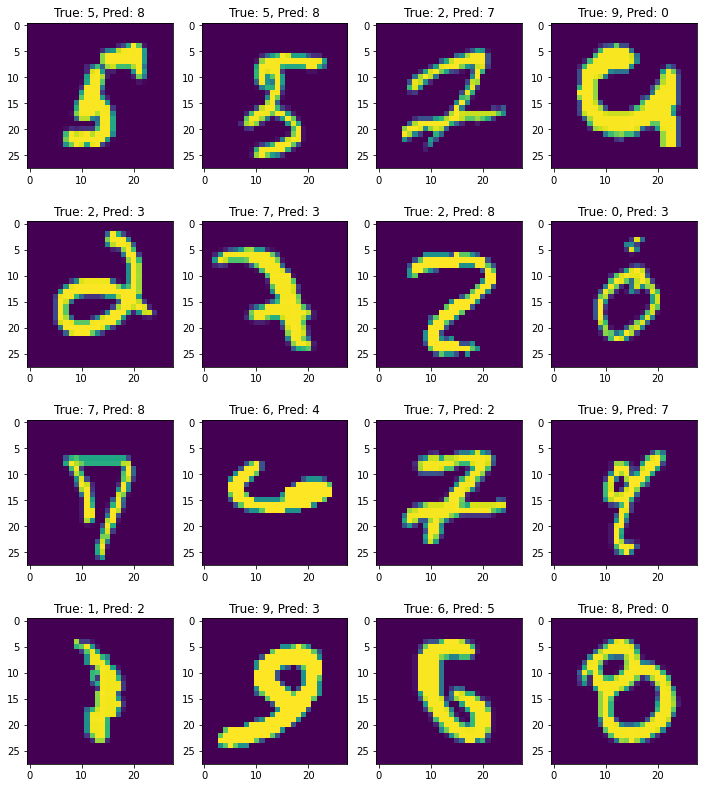

In [70]:
fig, ax = plt.subplots(4,4,figsize=(12,14)) 
ax = ax.ravel()
idxs = np.random.permutation(miss_ims.shape[0])

if len(idxs) < 16:
    print("Less than 16 misclassifications.")
else:
    for i in range(16):
        idx = idxs[i]
        ax[i].imshow(miss_ims[idx])
        ax[i].set_title(f'True: {miss_labels[idx]}, Pred: {miss_preds[idx]}')
    plt.show()